In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from astropy.table import Table
from astropy.time import Time
import numpy as np

In [3]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

In [4]:
class GrowthModel(Model):
    """
    Class to handle log-linear model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(GrowthModel,self).__init__(  **keywords)
        
        self.name='GrowthModel'
            
       
    
        self.parameters = ModelParameterArray()
      
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=10000,units=''))
        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=3,val_min=0.,val_max=10.,units=''))
       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=10.,units=''))
       
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=20,val_min=-10.,val_max=100.,units=''))
    
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    
    def assign_val(self,name,val):

        setattr(self.polymodel,name,val)
    
    
    
    #def lin_func(self,nu):
        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):

        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [5]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=np.array(time)

In [6]:
def get_data(name='Confirmed'):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']=='Italy']
    pd=ts.to_pandas()
    y=pd.values
    y=y.flatten()[4:].astype(np.int)
    t=pd.columns[4:]
    msk=y>0
    
    time=np.arange(1,len(t)+1)
    msk=time>20
    t=t[msk]
    data_table=Table([time[msk], y[msk], np.sqrt(y[msk]), np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,t)
    return data

In [7]:
from jetset.minimizer import fit_SED

In [8]:
name='Deaths'
data=get_data(name)
gm=GrowthModel()
gm.nu_min=0
gm.nu_max=100
gm.show_pars()

fm=FitModel(analytical=gm,name='test')
bfm,mm=fit_SED(fm,data,nu_fit_start=30,nu_fit_stop=50,minimizer='minuit')

name par type units     val      phys. bound. min phys. bound. max  log  frozen
---- -------- ----- ------------ ---------------- ---------------- ----- ------
 eta                1.000000e+00     0.000000e+00     1.000000e+04 False  False
  R0                3.000000e+00     0.000000e+00     1.000000e+01 False  False
 tau                1.000000e+00     0.000000e+00     1.000000e+01 False  False
 t_0                2.000000e+01    -1.000000e+01     1.000000e+02 False  False
filtering data in fit range = [3.000000e+01,5.000000e+01]
data length 17

*** start fit process ***
----- 

**************************************************************************************************
Fit report

Model: None
 model name name par type units     val      phys. bound. min phys. bound. max  log  frozen
----------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
GrowthModel  eta                3.360903e+00     0.000000e+00     1.000000e+04 False  False
GrowthModel  

/Users/orion/anaconda3/envs/jetset/lib/python3.7/site-packages/jetset-1.1.2-py3.7-macosx-10.9-x86_64.egg/jetset/model_manager.py:157: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)
/Users/orion/anaconda3/envs/jetset/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in power


In [9]:
y=bfm.fit_Model.eval(nu=data.data['nu_data'],get_model=True)

<IPython.core.display.Javascript object>


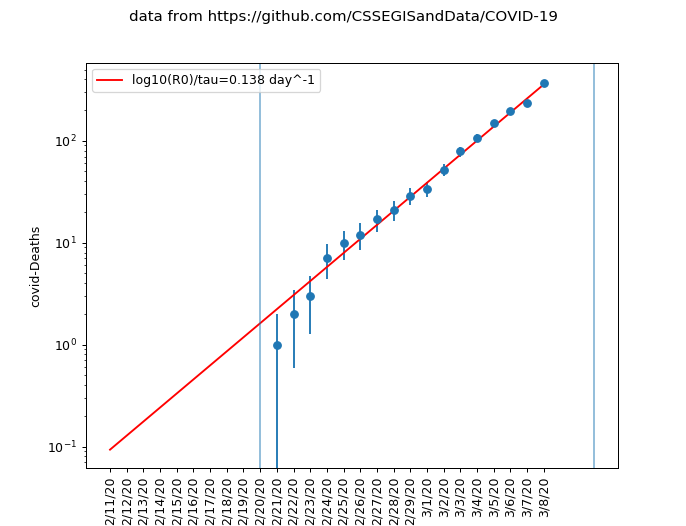

Text(0.5, 0.98, 'data from https://github.com/CSSEGISandData/COVID-19')

In [15]:
%matplotlib notebook
p=np.log10(gm.parameters.R0.best_fit_val)/gm.parameters.tau.val
plt.plot(data.data['nu_data'], y, 'r-',label='log10(R0)/tau=%3.3f day^-1'%p)
plt.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o')
plt.xlabel('date')
plt.ylabel('covid-%s'%name)
locs, labels = plt.xticks()
plt.xticks(data.data['nu_data'], data.time, rotation='vertical') 
plt.axvline(bfm.fit_Model.nu_min_fit,alpha=0.5)
plt.axvline(bfm.fit_Model.nu_max_fit,alpha=0.5)
plt.semilogy()
plt.legend()
plt.suptitle('data from https://github.com/CSSEGISandData/COVID-19')


In [11]:
from jetset.mcmc import McmcSampler

mcmc=McmcSampler(bfm.fit_Model,bfm.data)
mcmc.run_sampler(nwalkers=150,burnin=10,steps=500,bound=3,bound_rel=True,walker_start_bound=0.001,threads=1)

  1%|          | 5/500 [00:00<00:10, 48.99it/s]

mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 55.24it/s]

mcmc run done, with 1 threads took 9.08 seconds


In [12]:
mcmc.acceptance_fraction

0.2680533333333333

<IPython.core.display.Javascript object>


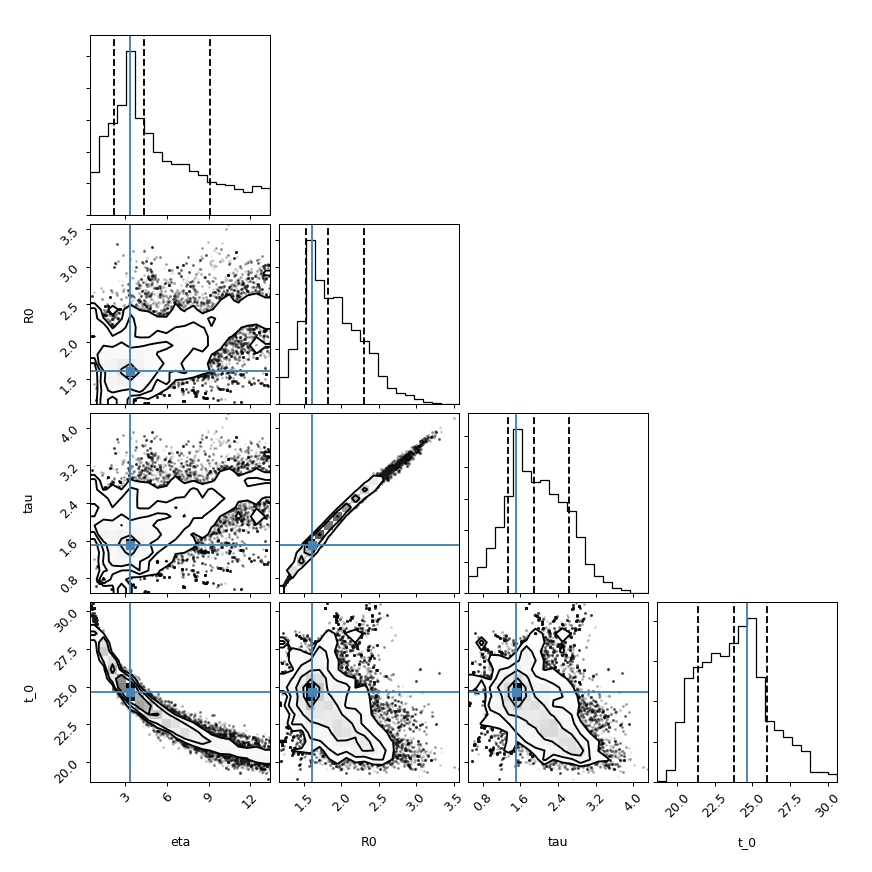

In [16]:
f=mcmc.corner_plot()

<IPython.core.display.Javascript object>


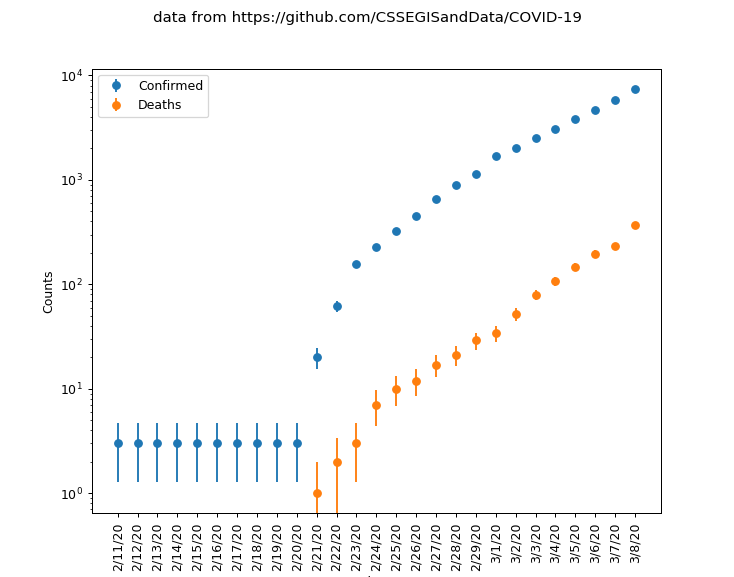

Text(0.5, 0.98, 'data from https://github.com/CSSEGISandData/COVID-19')

In [17]:
%matplotlib notebook

name='Confirmed'
data=get_data(name)
plt.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label='Confirmed')

name='Deaths'
data=get_data(name)
plt.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label='Deaths')

plt.xlabel('date')
plt.ylabel('Counts')
locs, labels = plt.xticks()
plt.xticks(data.data['nu_data'], data.time, rotation='vertical') 
plt.semilogy()
plt.legend()
plt.suptitle('data from https://github.com/CSSEGISandData/COVID-19')